In [2]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === 1. Load Your Real Preprocessed Data ===
X_all_normalized = np.load('preprocessed_data/X_all_normalized.npy')

with open('preprocessed_data/sym_all.pkl', 'rb') as f:
    sym_all = pickle.load(f)

In [3]:
# === 2. Map Beat Symbols to Class Indices ===
unique_classes = sorted(set(sym_all))
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
num_classes = len(unique_classes)

# Create y_all as integer class labels
y_all = np.array([label_to_index[sym] for sym in sym_all])

In [ ]:
# === 3. Load the Generated Class 'S' Samples ===
X_gen_S = np.load('generated_S_7998samples.npy')

# Determine class index for 'S'
s_index = label_to_index['S']
y_gen_S = np.full((X_gen_S.shape[0],), s_index)

In [6]:
# === 4. Combine Real + Synthetic Data ===
X_combined = np.vstack([X_all_normalized, X_gen_S])
y_combined = np.concatenate([y_all, y_gen_S])

In [7]:
# === 5. Shuffle the Dataset ===
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

In [8]:
# === 6. Reshape for Conv1D (add channel dimension) ===
X_combined = X_combined[..., np.newaxis]  # shape becomes (samples, 1080, 1)

# === 7. One-Hot Encode Labels ===
y_combined_categorical = to_categorical(y_combined, num_classes=num_classes)

In [ ]:
# === 8. Split into Train and Validation Sets (optional) ===
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined_categorical, test_size=0.2, random_state=42)

# === 9. Define Your CNN Model ===
model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-09 22:26:10.458702: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-09 22:26:10.458967: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-09 22:26:10.458983: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-09 22:26:10.459175: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-09 22:26:10.459194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2154, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1077, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1073, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 536, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 534, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 267, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68352)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,749,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,891,150 (33.92 MB)

 Trainable params: 8,891,150 (33.92 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import time
# Start timer
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, y_val)
)

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/15


2025-05-09 22:32:14.534422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


732/732 ━━━━━━━━━━━━━━━━━━━━ 72s 97ms/step - accuracy: 0.7209 - loss: 1.0836 - val_accuracy: 0.9310 - val_loss: 0.2508
Epoch 2/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 70s 96ms/step - accuracy: 0.9176 - loss: 0.3004 - val_accuracy: 0.9627 - val_loss: 0.1524
Epoch 3/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - accuracy: 0.9415 - loss: 0.2320 - val_accuracy: 0.9678 - val_loss: 0.1358
Epoch 4/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - accuracy: 0.9474 - loss: 0.2203 - val_accuracy: 0.9749 - val_loss: 0.1249
Epoch 5/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 70s 96ms/step - accuracy: 0.9498 - loss: 0.2109 - val_accuracy: 0.9750 - val_loss: 0.1325
Epoch 6/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - accuracy: 0.9546 - loss: 0.2061 - val_accuracy: 0.9731 - val_loss: 0.1706
Epoch 7/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 69s 95ms/step - accuracy: 0.9527 - loss: 0.2386 - val_accuracy: 0.9687 - val_loss: 0.2060
Epoch 8/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 69s 95ms/step - accuracy: 0.9501 - loss: 0.3105 - val_accurac

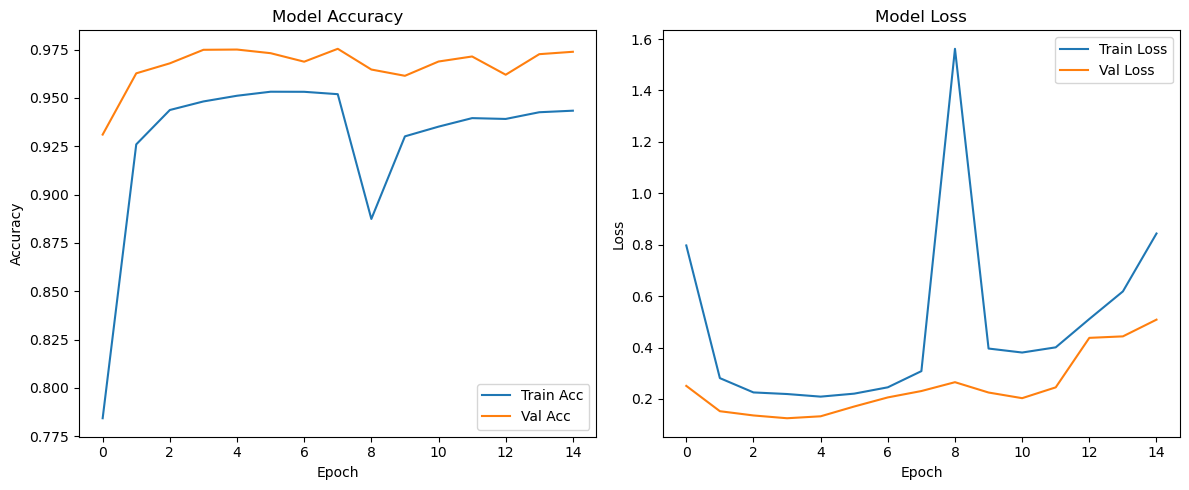

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

732/732 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

📊 Evaluation Metrics:
Accuracy  : 0.9738
Precision : 0.7129
Recall    : 0.6728
F1-score  : 0.6811


/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9891    0.9934    0.9913      1370
           1     0.9296    0.7645    0.8390       518
           2     1.0000    1.0000    1.0000        19
           3     0.9692    0.4468    0.6117       141
           4     0.0000    0.0000    0.0000        20
           5     0.9447    0.9837    0.9638      1599
           6     0.9830    0.9871    0.9850     15078
           7     0.9815    0.9890    0.9852      1450
           8     1.0000    1.0000    1.0000      1585
           9     0.9106    0.9597    0.9345      1390
          10     0.0000    0.0000    0.0000        24
          11     0.0000    0.0000    0.0000         1
          12     0.9783    0.7337    0.8385       184
          13     0.2949    0.5610    0.3866        41

    accuracy                         0.9738     23420
   macro avg     0.7129    0.6728    0.6811     23420
weighted avg     0.9731    0.9738    0.9724    

/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rxian/miniforge3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

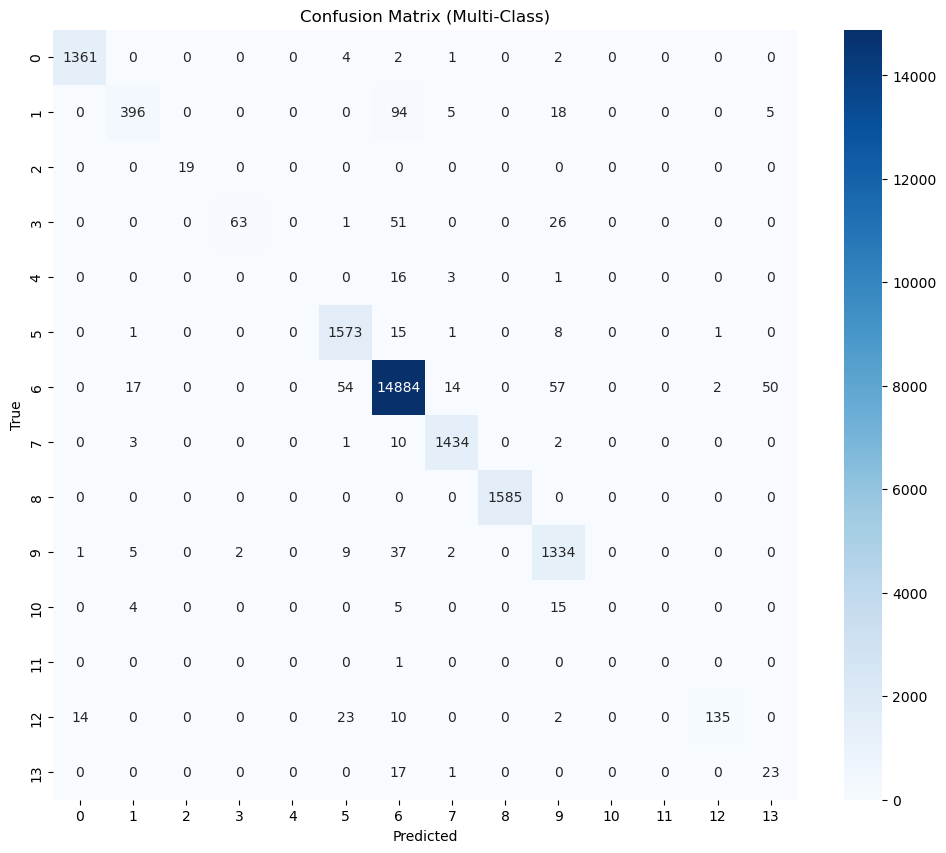

In [16]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

/var/folders/vy/h0yt7lx97b5ct5kp84j7dk_40000gn/T/ipykernel_5646/2068499492.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')


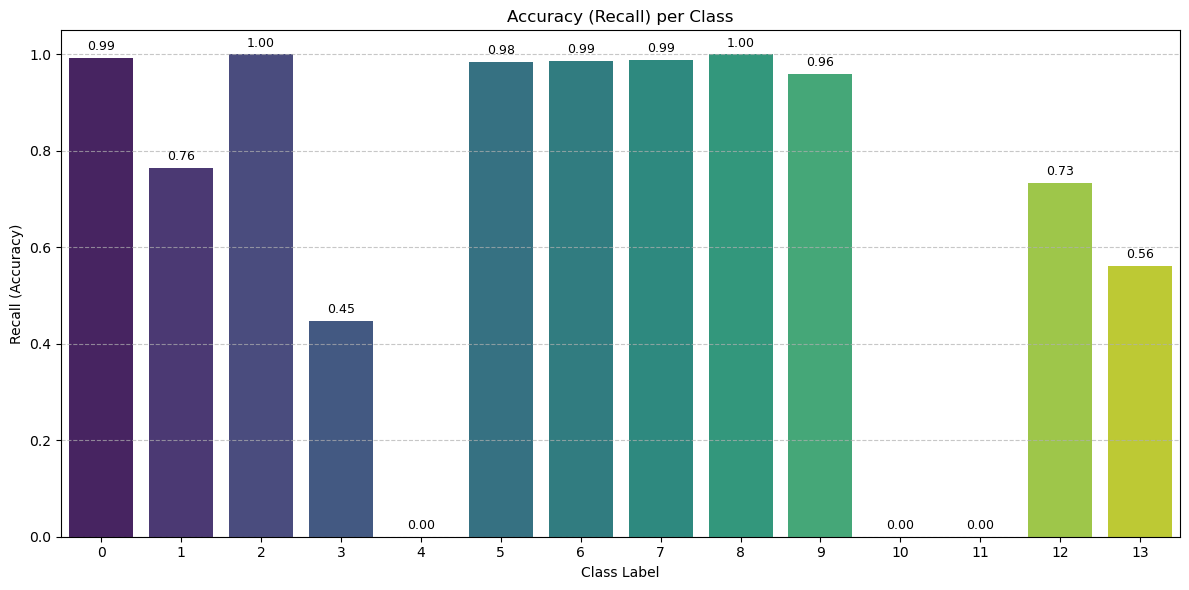

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.9934, 0.7645, 1.0000, 0.4468, 0.0000, 0.9837, 0.9871, 0.9890, 1.0000, 0.9597, 0.0000, 0.0000, 0.7337, 0.5610
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [19]:
s_index

8

In [20]:
import numpy as np

# Get unique class labels in the order they appear
unique_classes = sorted(set(sym_all))

# Show the index of each class
for idx, label in enumerate(unique_classes):
    print(f"Class index {idx}: {label}")

# Find the index of 'S'
s_index = unique_classes.index('S')
print(f"\n✅ Class 'S' index is: {s_index}")


Class index 0: /
Class index 1: A
Class index 2: E
Class index 3: F
Class index 4: J
Class index 5: L
Class index 6: N
Class index 7: R
Class index 8: S
Class index 9: V
Class index 10: a
Class index 11: e
Class index 12: f
Class index 13: j

✅ Class 'S' index is: 8
